## Step 3: Preparing data for training

**Objectives**
- 3.1. Importing daily scores from news folder
- 3.2. Importing daily stock data from stock folder
- 3.3. Merge both the imported data with date
- 3.4. Saving the merged data
- 3.5. Check data by plotting the graph

In [2]:
import pandas as pd
import json

import matplotlib.pyplot as plt

In [12]:
from google.colab import files
a = files.upload()
b = files.upload() #inputJsonFile = '/content/headlines.json' outputJsonFile = '/content/daily_scores.json'

Saving hbl.csv to hbl.csv


Saving hbl_feat.csv to hbl_feat.csv


### 3.1. Importing daily scores from news folder

In [8]:
with open('/content/daily_scores.json', 'r') as file:
    sentimentScores = json.load(file)
#endwith

dfSentiment = pd.DataFrame(list(sentimentScores.items()), columns=['jsonDate', 'sentiment'])
dfSentiment['date'] = pd.to_datetime(dfSentiment['jsonDate'], format='%Y-%m-%d')
dfSentiment.head()

,jsonDate,sentiment,date
0,2015-01-01,"[0.3070025146007538, 0.17011728882789612, 0.15...",2015-01-01
1,2015-01-02,"[0.282503217458725, 0.1561100333929062, 0.1806...",2015-01-02
2,2015-01-03,"[0.32533949613571167, 0.14950306713581085, 0.1...",2015-01-03
3,2015-01-04,"[0.32683512568473816, 0.17659184336662292, 0.1...",2015-01-04
4,2015-01-05,"[0.3772907555103302, 0.14218369126319885, 0.14...",2015-01-05


### 3.2. Importing daily stock data from stock folder
- Data used will be of Habib Bank Limited (HBL)
- This bank is considered to be the top performing and one of the most profitable bank in the country [[Source: AsiaMoney](https://www.asiamoney.com/article/2bp0xnj0tjyfvvwhd8oow/awards/best-bank-awards/pakistans-best-domestic-bank-2023-hbl)]
- This bank has branches outside Pakistan as well

In [15]:
csvFilePath = '/content/hbl.csv'
dfCsv = pd.read_csv(csvFilePath)
dfCsv.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,HBL,01-Oct-2015,198.00,200.50,196.80,197.87,426600
1,HBL,02-Oct-2015,199.00,200.00,198.00,198.27,370300
2,HBL,05-Oct-2015,198.03,198.51,197.11,198.01,47900
3,HBL,06-Oct-2015,199.90,204.49,199.00,203.25,157300
4,HBL,07-Oct-2015,203.00,204.65,202.00,204.00,130400


### 3.3. Merge both the imported data with date

In [16]:
dfCsv['date'] = pd.to_datetime(dfCsv['Date'], format='%d-%b-%Y')
dfMerged = pd.merge(dfCsv, dfSentiment, on='date', how='left')
dfSentimentColumns = pd.DataFrame(dfMerged['sentiment'].tolist(), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

dfMerged = dfMerged.drop(columns=['Symbol', 'date', 'sentiment', 'jsonDate'])
dfMerged.head()

,Date,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5
0,01-Oct-2015,198.00,200.50,196.80,197.87,426600,0.312187,0.163488,0.167254,0.178624,0.178447
1,02-Oct-2015,199.00,200.00,198.00,198.27,370300,0.299259,0.175934,0.165843,0.174329,0.184635
2,05-Oct-2015,198.03,198.51,197.11,198.01,47900,0.277948,0.170541,0.171659,0.191485,0.188367
3,06-Oct-2015,199.90,204.49,199.00,203.25,157300,0.327915,0.163137,0.156347,0.172104,0.180497
4,07-Oct-2015,203.00,204.65,202.00,204.00,130400,0.344828,0.175881,0.167450,0.156289,0.155552


### 3.4. Saving the merged data
- Saving the file in CSV format ([hbl_feat.csv](./data/stocks2023/hbl_feat.csv))

In [17]:
outputCsvPath = '/content/hbl_feat.csv'
dfMerged.to_csv(outputCsvPath, index=False)

### 3.5. Check data by plotting the graph

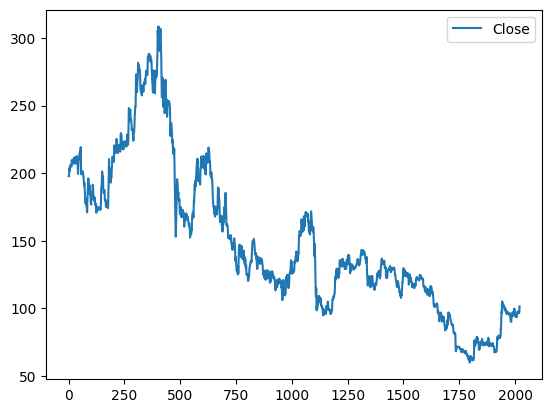

In [18]:
dfMerged[['Close']].plot()
plt.show()

## Step 4: Training on the merged dataset

**Objectives**
- 4.1. Importing the dataset
- 4.2. Creating a function to preprocess the dataset
- 4.3. Preproccessing the dataset for LSTM
- 4.4. Building the LSTM model
- 4.5. Testing the model

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### 4.1. Importing the dataset

In [20]:
csvFilePath = '/content/hbl_feat.csv'
df = pd.read_csv(csvFilePath)

### 4.2. Creating a function to preprocess the dataset
The `createDataset` function is designed to prepare data for training a time-series prediction model. It takes the input features (`dataset`), the target variable (`target`), and an optional parameter `lookBack`, which determines how many past time steps the model should consider. The function then iterates through the dataset, creating pairs of input sequences (`dataX`) and corresponding target values (`dataY`). For each iteration, a window of time steps equal to `lookBack` is taken from the dataset, and this window becomes a sequence in `dataX`. The target value corresponding to the last time step in the window is added to `dataY`. The function returns two arrays suitable for training a model, where each row in `dataX` represents a sequence of past observations, and the corresponding element in `dataY` is the target value to be predicted. This kind of dataset preparation is particularly useful for training models like Long Short-Term Memory (LSTM) networks, which can capture temporal dependencies in sequential data.

In [21]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

### 4.3. Preproccessing the dataset for LSTM
This section prepares data for training a LSTM network. It first extracts the features and the target variable (closing stock prices) from a DataFrame. Then it uses Min-Max scaling to normalize these features and the target variable, ensuring they fall within the range of 0 to 1. It utilizes the `createDataset` function, section 4.2, to structure the data into sequences suitable for training the LSTM model. The sequences represent past observations, and the corresponding targets are the next time step's closing prices to predict. Finally, the dataset gets divided into training and testing sets, and their dimensions are adjusted to fit the LSTM model's input requirements. The resulting `trainX`, `testX`, `trainY`, and `testY` are now ready for training and evaluating the LSTM model's performance in predicting future stock prices based on historical patterns.


In [22]:
features = df.drop(['Date', 'Close'], axis=1).values
target = df['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 3
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))


[[[0.55138989 0.54960317 0.55631951 0.01338521 0.665256   0.35111637
   0.36853442 0.32548157 0.51854583]
  [0.55539534 0.54761905 0.5611729  0.01159649 0.6239853  0.44725232
   0.35257396 0.30393062 0.55119562]
  [0.55151005 0.54170635 0.55757331 0.00135345 0.55595326 0.4055975
   0.41837064 0.39001635 0.57088665]]

 [[0.55539534 0.54761905 0.5611729  0.01159649 0.6239853  0.44725232
   0.35257396 0.30393062 0.55119562]
  [0.55151005 0.54170635 0.55757331 0.00135345 0.55595326 0.4055975
   0.41837064 0.39001635 0.57088665]
  [0.55900024 0.56543651 0.56521739 0.00482922 0.71546564 0.34840194
   0.24514347 0.29276543 0.52936289]]]
[[0.57643274]
 [0.57944902]]


### 4.4. Building the LSTM model

In [23]:
batchSize = 1
epoch = 20
neurons = 100
dropout = 0.6

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 100)         │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,901 (800.39 KB)

 Trainable params: 204,901 (800.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0268 - val_loss: 2.1459e-04
Epoch 2/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0045 - val_loss: 2.1912e-04
Epoch 3/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0035 - val_loss: 2.0820e-04
Epoch 4/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0028 - val_loss: 4.8015e-04
Epoch 5/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0023 - val_loss: 4.2963e-04
Epoch 6/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0023 - val_loss: 1.8885e-04
Epoch 7/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0022 - val_loss: 2.9729e-04
Epoch 8/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0025 - val_loss: 2.2050e-04
Epoch 9/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0022 - val_loss: 6.5259e-04
Epoch 10/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0021 - val_loss: 7.1660e-04
Epoch 11/20
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - 

### 4.5. Testing the model
- 4.5.1. Running prediction over the training set and testing set
- 4.5.2. Calculating the score and accuracy of the model
- 4.5.3. Visualizing the data

#### 4.5.1. Running prediction over the training set and testing set

In [24]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


#### 4.5.2. Calculating the score and accuracy of the model

In [25]:
trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
print(f'Testing RMSE: {testScore}')

trainAccuracy = 100 - (trainScore / np.mean(trainYInv) * 100)
testAccuracy = 100 - (testScore / np.mean(testYInv) * 100)

print(f'Training Accuracy: {trainAccuracy:.2f}%')
print(f'Testing Accuracy: {testAccuracy:.2f}%')

Training RMSE: 8.159711110119476
Testing RMSE: 11.13791156309112
Training Accuracy: 95.05%
Testing Accuracy: 86.67%


#### 4.5.3. Visualizing the data
- On the x-axis, the dates are displayed after every 30 days
- Test set is appended to the training set to better visualize if the prediction looks good

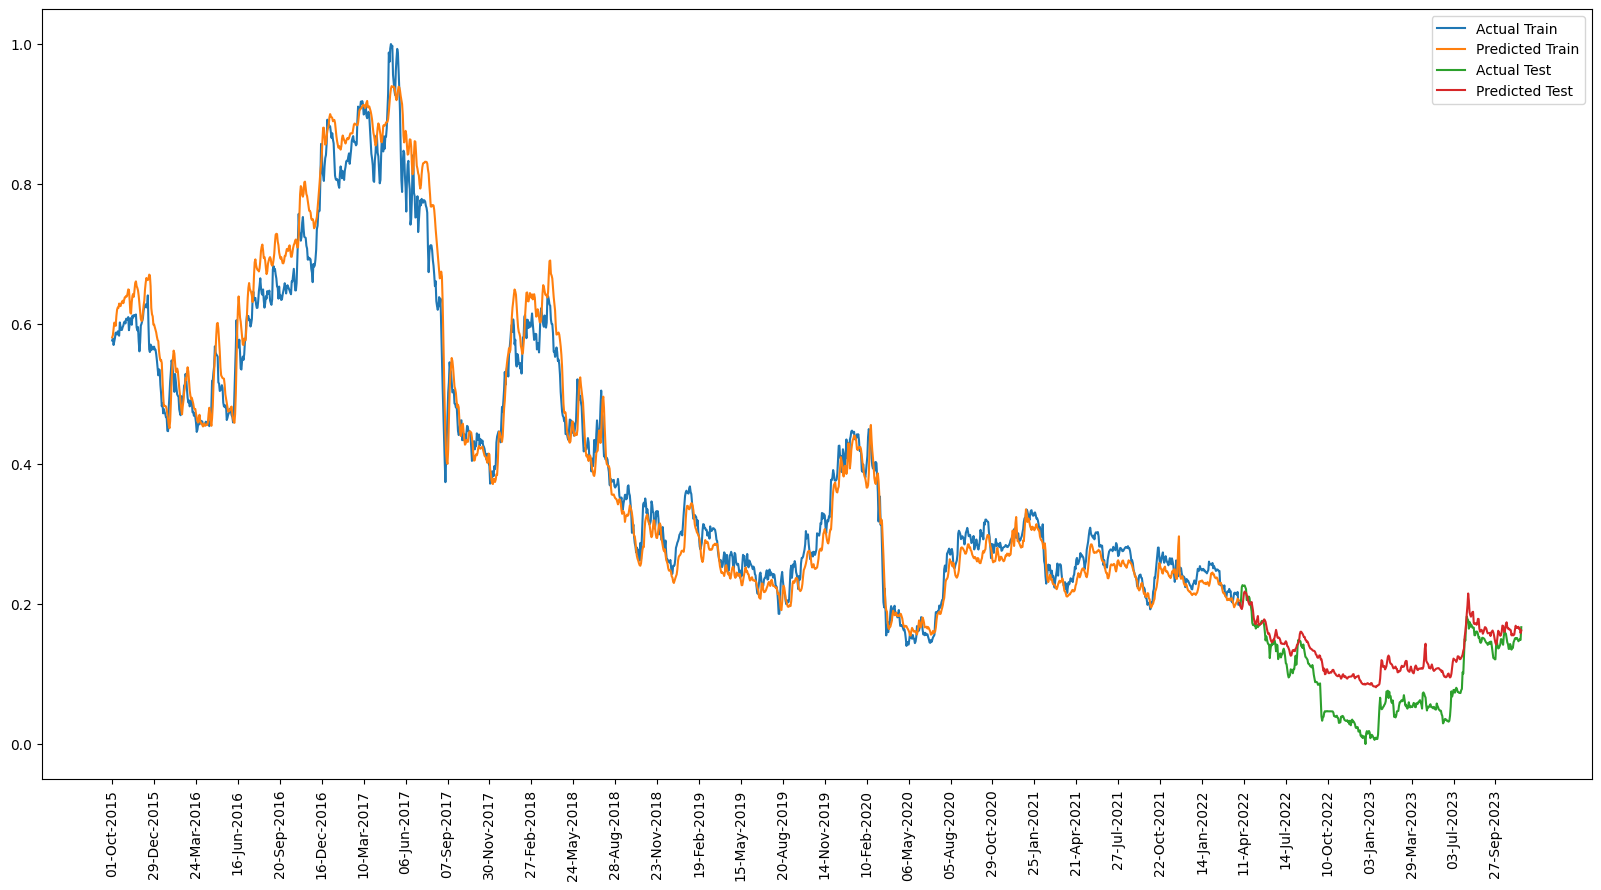

In [26]:
dates = df['Date'].values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()